**Mock Data Generation**

In [39]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate mock A/B test data
np.random.seed(42)

num_users_per_group = 5000
start_date = datetime(2023, 11, 1)
test_duration_days = 14  # 2-week test

# Control Group (A)
control_user_ids = [f'UserA_{10000+i}' for i in range(num_users_per_group)]
control_group_assignment = ['Control'] * num_users_per_group
control_conversions = np.random.binomial(1, 0.10, num_users_per_group)  # 10% baseline
control_clicks = np.random.randint(0, 15, num_users_per_group)
control_page_views = control_clicks + np.random.randint(1, 5, num_users_per_group)
control_page_views = np.maximum(1, control_page_views)

# Treatment Group (B) – slight uplift
treatment_user_ids = [f'UserB_{20000+i}' for i in range(num_users_per_group)]
treatment_group_assignment = ['Treatment'] * num_users_per_group
treatment_conversions = np.random.binomial(1, 0.115, num_users_per_group)  # 11.5%
treatment_clicks = np.random.randint(0, 17, num_users_per_group)
treatment_page_views = treatment_clicks + np.random.randint(1, 5, num_users_per_group)
treatment_page_views = np.maximum(1, treatment_page_views)

# Combine data
all_user_ids = control_user_ids + treatment_user_ids
all_groups = control_group_assignment + treatment_group_assignment
all_conversions = np.concatenate([control_conversions, treatment_conversions])
all_clicks = np.concatenate([control_clicks, treatment_clicks])
all_page_views = np.concatenate([control_page_views, treatment_page_views])

# Assign random dates within the test period
all_dates = [
    (start_date + timedelta(days=np.random.randint(0, test_duration_days))).strftime('%Y-%m-%d')
    for _ in range(num_users_per_group * 2)
]

# Create DataFrame
df_ab_test = pd.DataFrame({
    'UserID': all_user_ids,
    'Group': all_groups,
    'Date': all_dates,
    'PageViews': all_page_views,
    'Clicks': all_clicks,
    'Converted': all_conversions
})

# Ensure clicks are not more than page views
df_ab_test['Clicks'] = df_ab_test.apply(
    lambda row: min(row['Clicks'], row['PageViews']),
    axis=1
)


In [40]:
df_ab_test.to_csv('ab_test_results_mock_data.csv', index=False)
print("Mock A/B test data generated: ab_test_results_mock_data.csv")
print(df_ab_test.sample(10, random_state=42))

Mock A/B test data generated: ab_test_results_mock_data.csv
           UserID      Group        Date  PageViews  Clicks  Converted
6252  UserB_21252  Treatment  2023-11-07          8       4          0
4684  UserA_14684    Control  2023-11-10          5       1          0
1731  UserA_11731    Control  2023-11-04          8       6          0
4742  UserA_14742    Control  2023-11-12          3       2          0
4521  UserA_14521    Control  2023-11-12         12       8          0
6340  UserB_21340  Treatment  2023-11-03          7       3          0
576   UserA_10576    Control  2023-11-08          4       0          0
5202  UserB_20202  Treatment  2023-11-05         15      14          1
6363  UserB_21363  Treatment  2023-11-12         16      14          1
439   UserA_10439    Control  2023-11-08          9       8          0


Objective:

Analyze the results of an A/B test conducted on a website to determine if a new feature (treatment group) had a statistically significant impact on a key metric (e.g., conversion rate, click-through rate) compared to the existing version (control group).

In [41]:
# This A/B test evaluates whether introducing a new website feature (Treatment group) improves the conversion rate compared to the existing version (Control group).

# Hypothesis:
# Null (H₀): No difference in conversion rates between Control and Treatment groups.
# Alternative (H₁): Conversion rates differ between the two groups.

# Key Metric:
# Primary: Conversion Rate = Converted Users / Total Users
# Secondary (Optional): Clicks, Page Views

# Group Assignment:
# 5,000 users in each group (Control & Treatment)
# Assigned randomly using unique user IDs with clear separation
# No overlap between groups

# Test Duration:
# 14 days
# Start Date: November 1, 2023
# User activity is distributed randomly across the test window

**Data Loading and Cleaning**

In [42]:
data = pd.read_csv("/content/ab_test_results_mock_data.csv")
data.head()

,UserID,Group,Date,PageViews,Clicks,Converted
0,UserA_10000,Control,2023-11-08,5,2,0
1,UserA_10001,Control,2023-11-14,8,7,1
2,UserA_10002,Control,2023-11-03,7,6,0
3,UserA_10003,Control,2023-11-06,6,2,0
4,UserA_10004,Control,2023-11-03,6,5,0


In [43]:
# 1. Check for duplicate users
duplicate_users = data['UserID'].duplicated().sum()
print(f"Users appearing more than once: {duplicate_users}")

Users appearing more than once: 0


In [44]:
# 2. Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 UserID       0
Group        0
Date         0
PageViews    0
Clicks       0
Converted    0
dtype: int64


In [45]:
# 3a. Check for invalid Clicks > PageViews
invalid_clicks = (data['Clicks'] > data['PageViews']).sum()
print(f" Rows where Clicks > PageViews: {invalid_clicks}")

 Rows where Clicks > PageViews: 0


In [46]:
# 3b. Check for 0 or negative PageViews
bad_pageviews = (data['PageViews'] <= 0).sum()
print(f"Users with 0 or negative pageviews: {bad_pageviews}")

Users with 0 or negative pageviews: 0


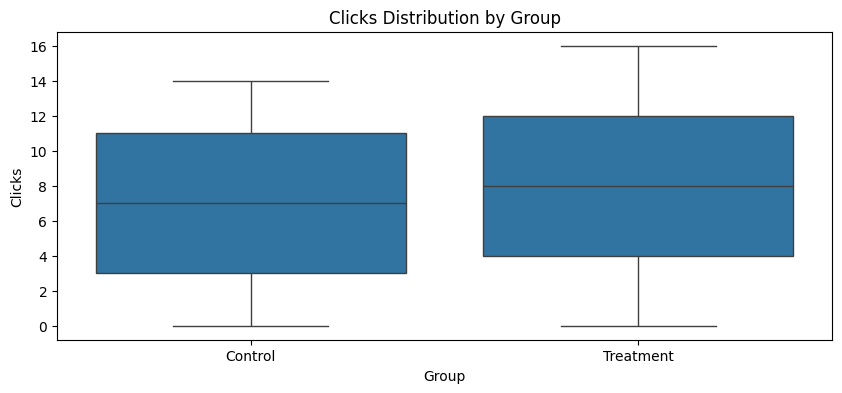

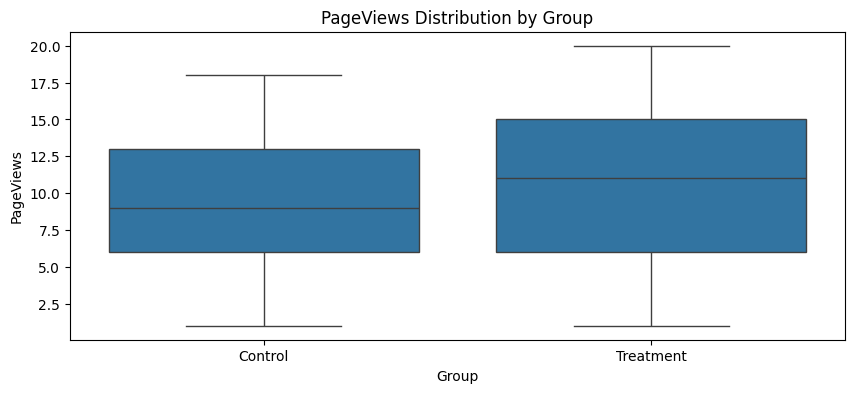

In [47]:
# 4. Optional: Visualize outliers
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(x='Group', y='Clicks', data=data)
plt.title("Clicks Distribution by Group")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x='Group', y='PageViews', data=data)
plt.title("PageViews Distribution by Group")
plt.show()

In [48]:
# Check if any user is im both groups
user_counts = data.groupby('UserID')['Group'].nunique()
overlap_users = user_counts[user_counts > 1].count()
print(f"Users assigned to both groups: {overlap_users}")

Users assigned to both groups: 0


In [49]:
group_sizes = data['Group'].value_counts()
print(" Number of users per group:\n", group_sizes)

 Number of users per group:
 Group
Control      5000
Treatment    5000
Name: count, dtype: int64


In [50]:
data.groupby('Group')['UserID'].apply(lambda ids: ids.str.startswith('UserA_').mean())

,UserID
Group,
Control,1.0
Treatment,0.0


In [51]:
# Group Assignment Validation

# - No users appear in both Control and Treatment groups — groups are mutually exclusive.
# - Each group contains exactly 5,000 users, ensuring a balanced test.
# - User IDs are uniquely prefixed (`UserA_` for Control, `UserB_` for Treatment), confirming proper assignment.

# → Group assignment is valid and ready for analysis.


**Key Metrics**

In [52]:
# Group by Control and Treatment and calculate average conversion
conversion_rates = data.groupby('Group')['Converted'].agg(['count', 'sum', 'mean']).rename(columns={
    'count': 'Total Users',
    'sum': 'Total Conversions',
    'mean': 'Conversion Rate'
})

print(conversion_rates)


           Total Users  Total Conversions  Conversion Rate
Group                                                     
Control           5000                479           0.0958
Treatment         5000                590           0.1180


In [53]:
cr_control = 0.0958
cr_treatment = 0.1180

difference = cr_treatment - cr_control
print(f"Observed Difference in Conversion Rate: {difference:.4f}")


Observed Difference in Conversion Rate: 0.0222


**Statistical Significance Testing**

###  Chosen Statistical Test

We will use a **two-tailed Z-test for proportions** to determine whether the difference in conversion rates between the Control and Treatment groups is statistically significant.

- This test is appropriate because:
  - The outcome (conversion) is binary.
  - We are comparing **proportions** across **two independent groups**.
  - The sample size is large (n > 30 for both groups), satisfying conditions for normal approximation.


In [54]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

# Group counts
control_conversions = 479
treatment_conversions = 590
n_control = 5000
n_treatment = 5000

# Z-test for proportions
counts = np.array([treatment_conversions, control_conversions])
nobs = np.array([n_treatment, n_control])

z_stat, p_value = proportions_ztest(counts, nobs, alternative='two-sided')

# Confidence Interval for the difference
ci_low, ci_upp = confint_proportions_2indep(count1=treatment_conversions,
                                            nobs1=n_treatment,
                                            count2=control_conversions,
                                            nobs2=n_control,
                                            method='wald')

print(f" Z-statistic: {z_stat:.4f}")
print(f" p-value: {p_value:.4f}")
print(f" 95% Confidence Interval for Difference: ({ci_low:.4f}, {ci_upp:.4f})")

# Check statistical significance
alpha = 0.05
if p_value < alpha:
    print(" Statistically significant difference (Reject H₀)")
else:
    print(" Not statistically significant (Fail to reject H₀)")

 Z-statistic: 3.5924
 p-value: 0.0003
 95% Confidence Interval for Difference: (0.0101, 0.0343)
 Statistically significant difference (Reject H₀)


### Practical Significance

- The observed **2.22% absolute uplift** (23% relative) in conversion rate is both **statistically** and **practically** significant.
- Even the lower bound of the 95% confidence interval (1.01%) indicates a meaningful improvement.
- In real-world terms, this uplift could translate to thousands of extra conversions per month.
Therefore, the new feature not only passes statistical testing — it also offers tangible business value.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


###  Power Analysis Consideration

Since the test result is **statistically significant (p = 0.0003)** and the confidence interval excludes zero,  
a power analysis is **not required**. The sample size (n = 5,000 per group) was sufficient to detect the observed effect.


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 🧠 Final Interpretation & Recommendation

- The A/B test revealed a statistically significant uplift in conversion rate:
  - Control Group: 9.58%
  - Treatment Group: 11.80%
  - Absolute Difference: +2.22%
- p-value = 0.0003 (significant), 95% CI = (1.01%, 3.43%)
- This result is both **statistically and practically significant**.

 **Conclusion:**  
The new feature had a **positive impact** on conversion rates.

 **Recommendation:**  
Proceed with a **full rollout** of the feature.

 **Optional Next Step:**  
Segment the results (e.g., new vs. returning users) to identify if certain user groups responded better.
